In [1]:
pip install pmdarima

                                              0.0/614.7 kB ? eta -:--:--
     -----------------                      276.5/614.7 kB 5.7 MB/s eta 0:00:01
     -------------------------------------- 614.7/614.7 kB 7.7 MB/s eta 0:00:00
                                              0.0/301.2 kB ? eta -:--:--
     ---------------------------------------- 301.2/301.2 kB ? eta 0:00:00
                                              0.0/2.8 MB ? eta -:--:--
     -----------------------                  1.6/2.8 MB 51.9 MB/s eta 0:00:01
     ---------------------------------------- 2.8/2.8 MB 35.6 MB/s eta 0:00:00
                                              0.0/10.6 MB ? eta -:--:--
     ----------                               2.9/10.6 MB 92.5 MB/s eta 0:00:01
     ----------------------                   6.0/10.6 MB 76.7 MB/s eta 0:00:01
     ----------------------------------       9.3/10.6 MB 74.1 MB/s eta 0:00:01
     --------------------------------------  10.6/10.6 MB 73.1 MB/s eta 0:00:0


[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

<h1>Read Data</h1>

In [92]:
df = pd.read_csv('./microsoft_stock.csv')

In [93]:
df = df.set_index('Date')

In [94]:
df.index = pd.to_datetime(df.index)
df.shape

(1511, 5)

In [95]:
df = df[['Close']]

<h1>Plot Data</h1>

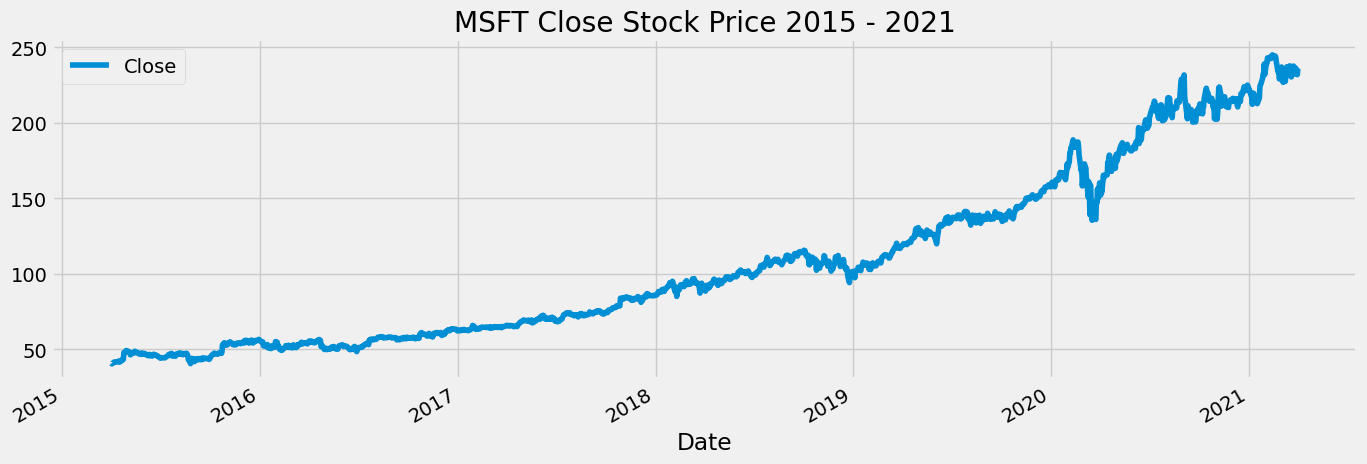

In [96]:
df.plot(figsize=(15, 5),
        color=color_pal[0],
        title='MSFT Close Stock Price 2015 - 2021')
plt.show()

<h1>Check For Stationarity</h1>

<h3>Visual inspection suggests non-stationarity in the data; however, we will confirm using statistical tests.</h3>

<h1>Method #1: ACF plot and PACF plot</h1>

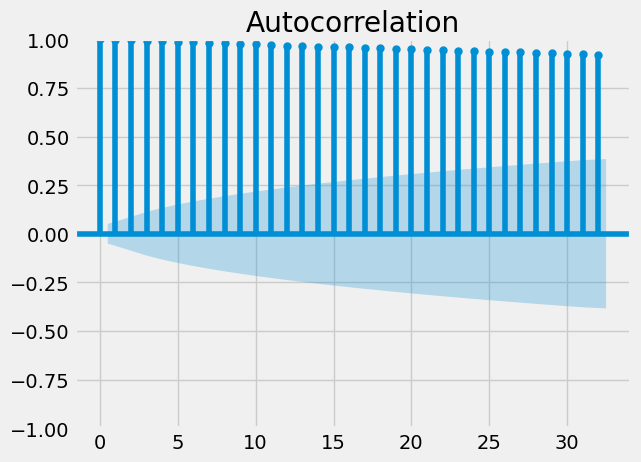

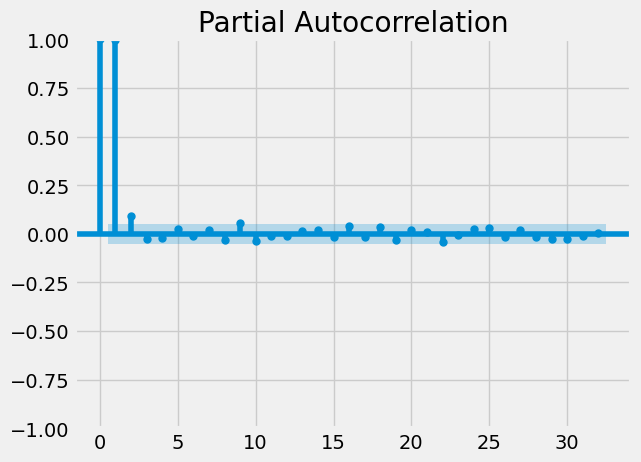

In [97]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf_original = plot_acf(df['Close'])

pacf_original = plot_pacf(df['Close'])


<h1>Method #2: ADF Test</h1>

In [98]:
from statsmodels.tsa.stattools import adfuller

def adf_test(dataset):
  dftest = adfuller(dataset, autolag = 'AIC')
  print("1. ADF : ",dftest[0])
  print("2. P-Value : ", dftest[1])
  print("3. Num Of Lags : ", dftest[2])
  print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
  print("5. Critical Values :")
  for key, val in dftest[4].items():
      print("\t",key, ": ", val)

In [99]:
adf_test(df['Close'])

1. ADF :  1.7371362899270988
2. P-Value :  0.9982158366942122
3. Num Of Lags :  24
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 1486
5. Critical Values :
	 1% :  -3.4347582315402434
	 5% :  -2.863486949792871
	 10% :  -2.567806534528638


<h3>P Value is greater than 0.05, hence we can conclude that data is not stationary</h3>

<h1>Making Time Series Stationary</h1> 

<h4>We applied a log function and first-order differencing to remove trend and seasonality from the data.</h4>

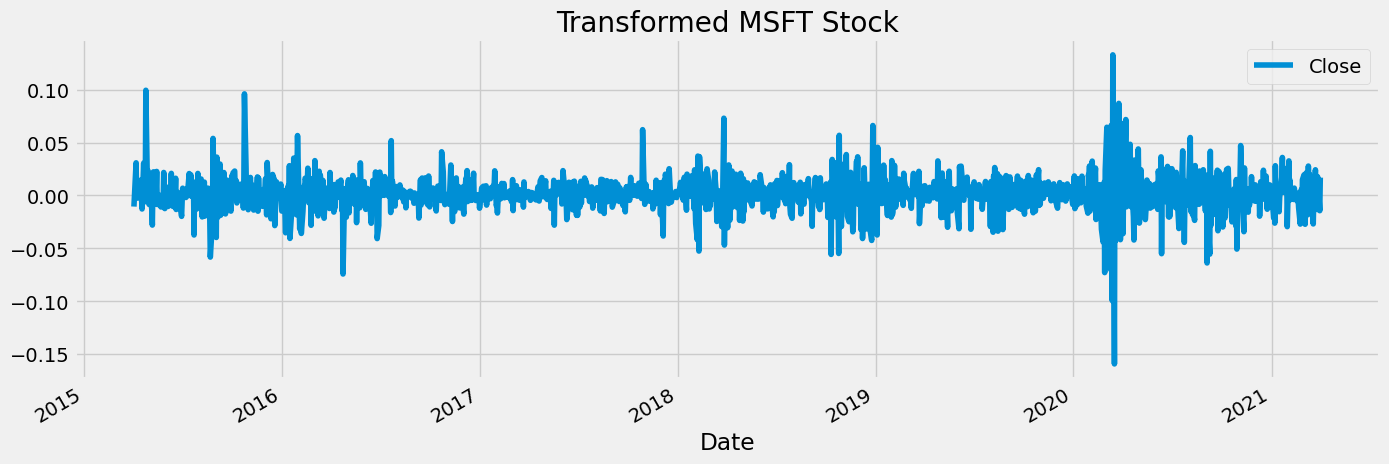

In [100]:
transformed_df = np.log(df).dropna()
transformed_df_diff = transformed_df.diff().dropna()
transformed_df_diff.plot(figsize=(15, 5),
        color=color_pal[0],
        title='Transformed MSFT Stock')
plt.show()

<h1>Check For Stationarity</h1>

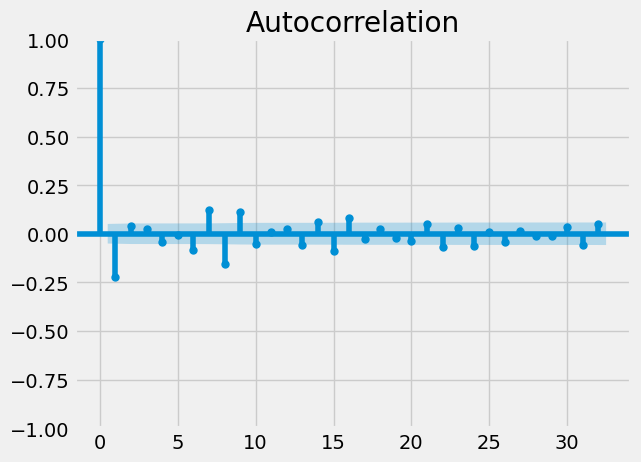

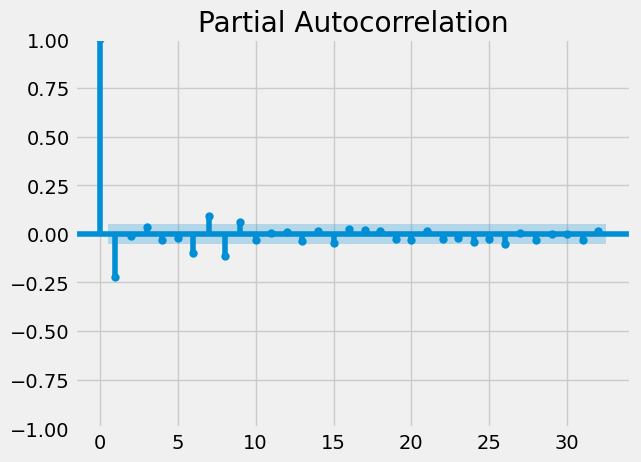

In [101]:
acf_diff = plot_acf(transformed_df_diff)

pacf_diff = plot_pacf(transformed_df_diff)

In [102]:
adf_test(transformed_df_diff)

1. ADF :  -13.801078367732226
2. P-Value :  8.569244684648421e-26
3. Num Of Lags :  8
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 1501
5. Critical Values :
	 1% :  -3.4347141029098758
	 5% :  -2.8634674740559594
	 10% :  -2.5677961635037003


<h4>P-Value is way less than the required 0.05, here we can conclude the data is stationary</h4>

<h1>Split Data For Training And Testing</h1>

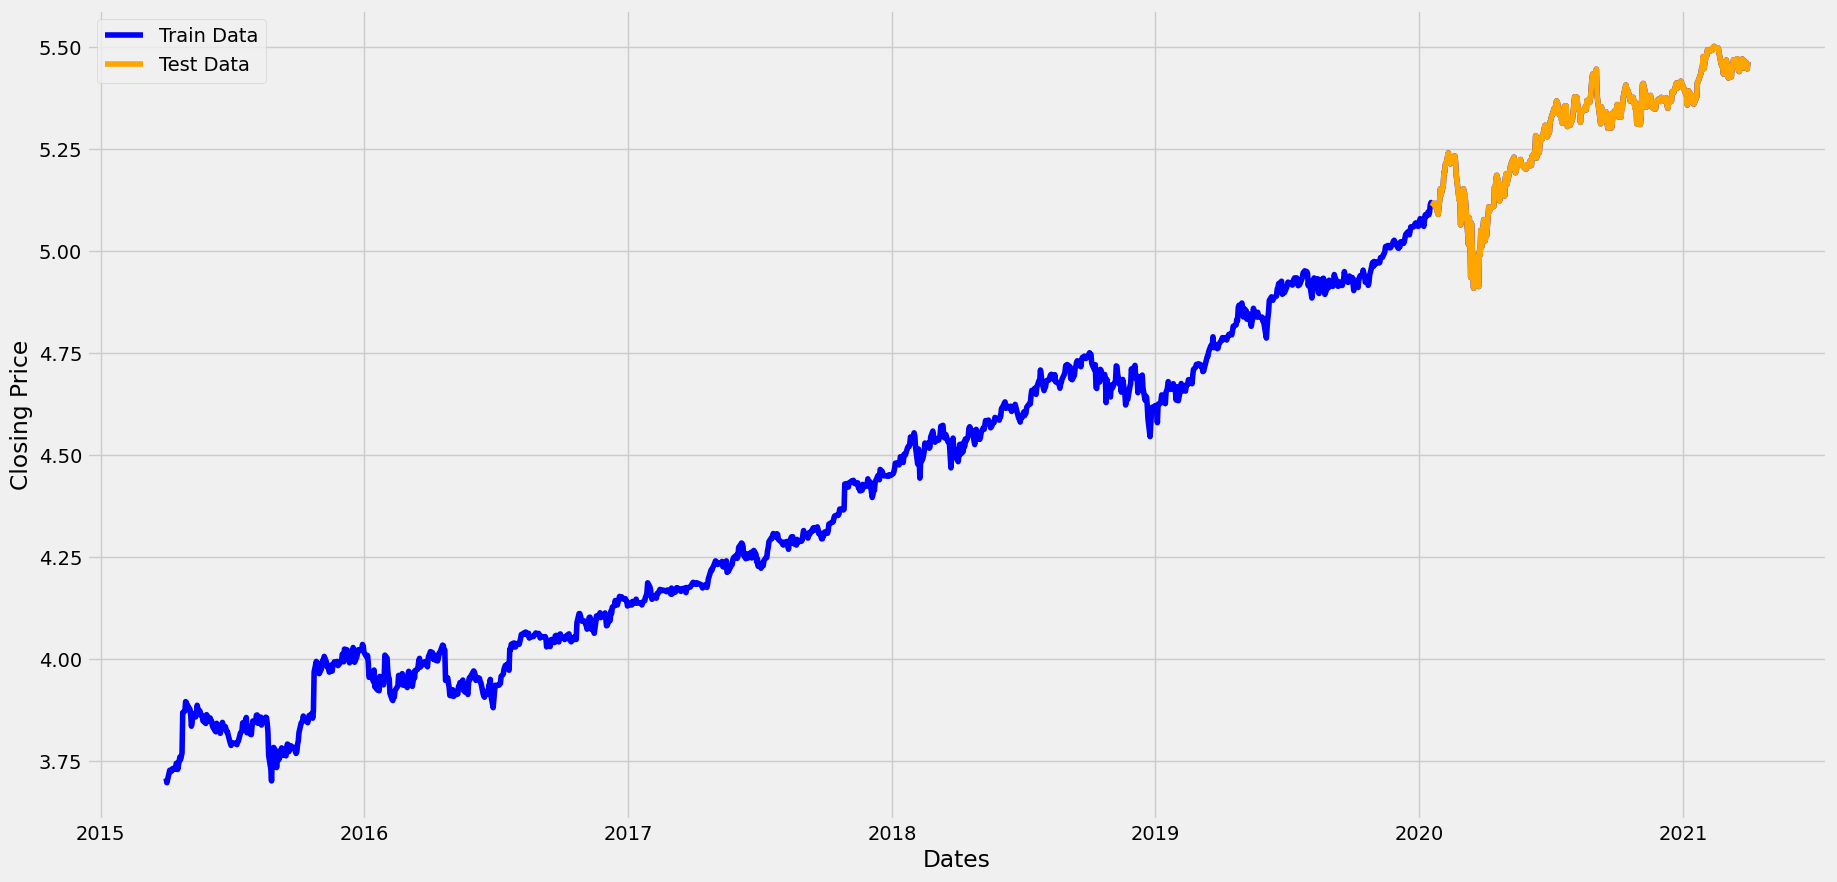

In [103]:
train_data,test_data = transformed_df[:int(len(transformed_df)*0.80)],transformed_df[int(len(transformed_df)*0.80):]
plt.figure(figsize=(20,10))
plt.xlabel('Dates')
plt.ylabel('Closing Price')
plt.plot(transformed_df, 'blue',label='Train Data')
plt.plot(test_data,'orange',label='Test Data')
plt.legend()
plt.show()

<h1>Deciding Order For ARIMA Model</h1>

<h4>We used auto-arima function to decide the parameters for the ARIMA Model (p,d,q)</h4>

In [104]:
import pmdarima as pm
auto_arima = pm.auto_arima(train_data, stepwise=False, seasonal=False,trace=True)
auto_arima.summary()

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-6804.349, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-6812.298, Time=0.36 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-6815.897, Time=1.02 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-6814.197, Time=1.06 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=-6815.526, Time=0.64 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=-6818.452, Time=0.82 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-6811.007, Time=0.27 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-6814.300, Time=0.52 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-6814.429, Time=0.67 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-6811.973, Time=0.93 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-6813.923, Time=0.82 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-6815.948, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-6814.663, Time=0.74 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-6812.157, Time=0.59 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-6809.543, Time=1.45

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1208
Model:               SARIMAX(0, 1, 5)   Log Likelihood                3416.226
Date:                Mon, 13 May 2024   AIC                          -6818.452
Time:                        17:01:51   BIC                          -6782.781
Sample:                             0   HQIC                         -6805.019
                               - 1208                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0012      0.000      3.568      0.000       0.001       0.002
ma.L1         -0.0887      0.020     -4.376      0.000      -0.128      -0.049
ma.L2         -0.0682      0.023     -2.955      0.003      -0.113      -0.023
ma.L3          0.0168      0.026      0.651      0.515      -0.034       0.067
ma.L4         -0.0474      0.025     -1.900      0.057      -0.096       0.002
ma.L5         -0.0643      0.026     -2.509      0.012      -0.115      -0.014
sigma2         0.0002   4.16e-06     49.007      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):              1959.44
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               0.80   Skew:                             0.23
Prob(H) (two-sided):                  0.02   Kurtosis:                         9.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<h1>Making Time Series Predictions</h1>

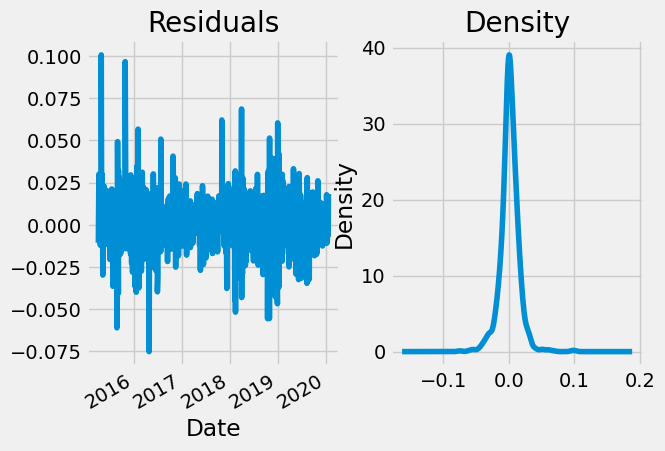

In [119]:
import matplotlib.pyplot as plt
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

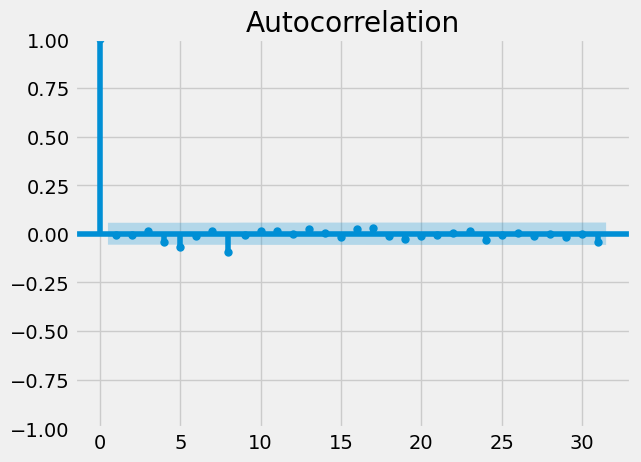

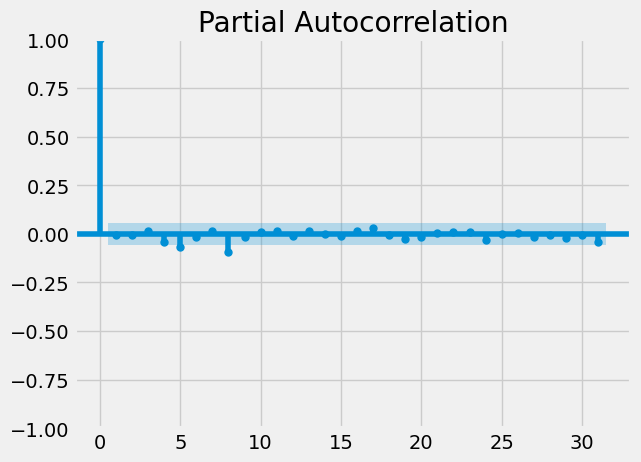

In [120]:
acf_res = plot_acf(residuals)

pacf_res = plot_pacf(residuals)

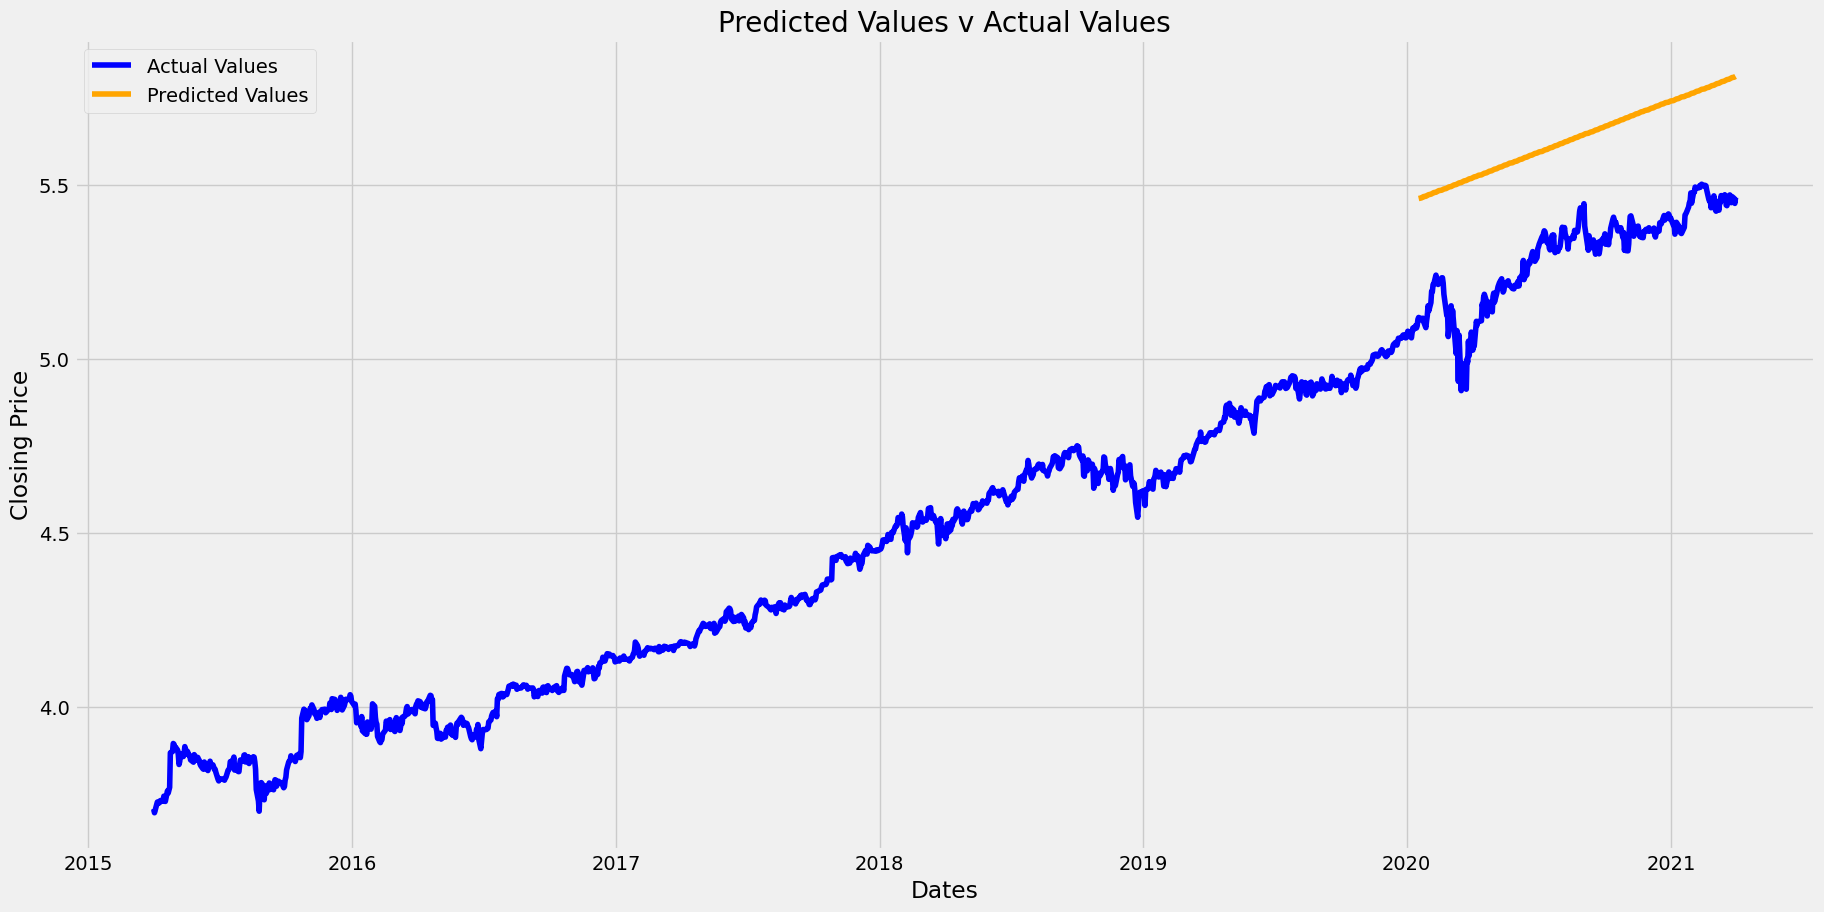

In [115]:
forecast_test_auto = auto_arima.predict(n_periods=len(test_data))
transformed_df['forecast_auto'] = [None]*len(train_data) + list(forecast_test_auto)

plt.figure(figsize=(20,10))
plt.xlabel('Dates')
plt.ylabel('Closing Price')
plt.title('Predicted Values v Actual Values')
plt.plot(transformed_df['Close'], 'blue',label='Actual Values')
plt.plot(transformed_df['forecast_auto'],'orange',label='Predicted Values')
plt.legend()
plt.show()

<h4>Once we identified the parameters for ARIMA model, we train our data using that model and made predictions on our test data set</h4>

<h4>As we can see in the plot, the predictions aren't perfectly accurate but it does capture the increasing trend in the dataset</h4>

<h1>Evaluating Predictions</h1>

<h4>We can evaluate the prediction using some statitical tests</h4>

In [116]:
mae = mean_absolute_error(test_data, forecast_test_auto)
mape = mean_absolute_percentage_error(test_data, forecast_test_auto)
rmse = np.sqrt(mean_squared_error(test_data, forecast_test_auto))

print(f'mae : {mae}')
print(f'mape : {mape}')
print(f'rmse : {rmse}')

mae - auto: 0.33589185107360175
mape - auto: 0.0636238841739844
rmse - auto: 0.3418787442385733


<h4>Mean Absolute Error (MAE):</h4>

<p>MAE measures the average absolute difference between the predicted values and the actual values.s.</p>

cmmm